In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
rng = np.random.default_rng()

A type-$k$ cell denotes a cell with $k$ driver mutations. This process starts $N$ type-$0$ cells.

In [4]:
N = 100
K = 3 # Total number of cell-types

def reset(): # This function is used to initiate a population of cells with k types
	pops = np.zeros(K+1, dtype=int) # Initiate cell populations
	pops[0] = N

	return pops

cell_populations = reset()

print(cell_populations)
print('Just 100 Wild Type Cells')

[100   0   0   0]
Just 100 Wild Type Cells


A type-$k$ cell can do three things: divide with rate $b_k$, die with rate $d_k$, or mutate into a type-$(k+1)$ cell with rate $u_{k+1}$. We will assume that the net growth rate of type-$k$ cells is $b_k - d_k = \lambda_k > 0$ and that $\lambda_{k+1} > \lambda_{k}$ for all $k \geq 1$. We need to initiate these rates for our simulation. In this case, the growth rate of cells stays the same, but we 

In order for the Gillespie algorithm to work: we have to know how long it takes to the next event (tau) and which event happens 

Division rates:  [0.25 0.25 0.25 0.25]
Death rates:  [0.25    0.075   0.0225  0.00675]
Mutation rates:  [0.005 0.005 0.005 0.   ]


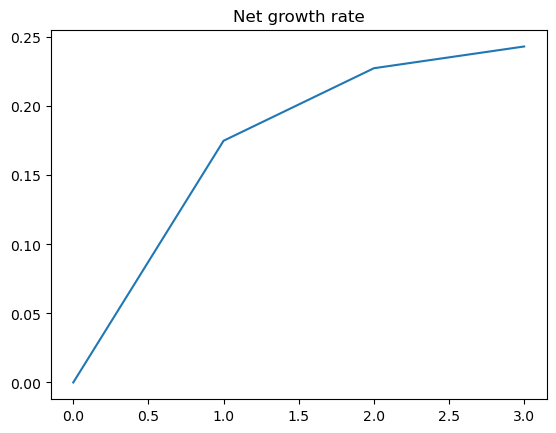

In [52]:
s = 0.7 # How much does each intensity actually help our cell? Closer to 0 = slight advantage for the wild- type cells 

u = 5e-3 # Mutation rate

growth_rates = 0.25*np.ones(K+1) # Growth rates remain constant

death_rates = np.array([0.25*(1-s)**k for k in range(K+1)]) # Death rates decrease over types

mutation_rates = u*np.ones(K+1) # Set mutation rates to u
mutation_rates[-1] = 0

print("Division rates: ", growth_rates)
print("Death rates: ", death_rates)
print("Mutation rates: ", mutation_rates)

plt.plot(growth_rates - death_rates)
plt.title("Net growth rate")
plt.show()

Using these rates, we can write helper functions to compute the time to the next event, choose which event happens, and actually perform the event on our population

In [53]:
mutation_rates

array([0.005, 0.005, 0.005, 0.   ])

In [54]:
def next_event_time(populations):
	total_rates_pc = growth_rates + death_rates + mutation_rates # Total rates per capita for each type
	total_rate = np.sum(total_rates_pc @ populations) # Compute total rate over all cells

	if total_rate == 0: # If all cells have died
		return -1
	
	return rng.exponential(1/total_rate) # Generate time to next event

Since there are so many events now, we need to be more clever about how we determine which event we choose. One way to do this in this case (certainly not the only way) is to arrange our events into a grid:

|    $k$   |  0  |  1  |  2  |  3  |
| -------- | --- | --- | --- | --- |
| **Division** |  0  |  1  |  2  |  3  |
|  **Death**   |  4  |  5  |  6  |  7  |
| **Mutation** |  8  |  9  |  10 |  11 |

Then, event numbers $e$ for which $e \mathop{\textrm{mod}} 4 = k$ happen to type $k$ and we can determine whether a division, death, or mutation occured by looking at the remainder when we divide by 4

In [55]:
def next_event(populations):
	total_growth_rates = growth_rates * populations
	total_death_rates = death_rates * populations
	total_mutation_rates = mutation_rates * populations

	event_rates = np.concatenate((total_growth_rates,total_death_rates,total_mutation_rates)) # Our 11 possible rates (V0- V11)
	sum_event_rates = np.cumsum(event_rates) # Sum of event rates, stepwise
	totalRate = sum_event_rates[-1] # Our total final rate

	event = rng.uniform(0,totalRate) # Generating a random number somewhere along this interaval 
	event_num = 0;
	# print(event)


	# Which bin did I land in? (From the event rates)
	while event > (sum_event_rates[event_num]):

		event_num += 1
		

		# e % 4 == k
	# ### TO FILL IN ###: # Figure our which event happened
	# 	### TO FILL IN ###;
	return event_num

In [56]:
def do_event(populations, E):
	event_target = E % 4 ## TO FILL IN ### # Figure out which cell-type the event happens to
	event_type =  np.floor(E/4) ### TO FILL IN ### # Figure out which type of event happens

	if event_type == 0: # Division event
		populations[event_target] += 1
	elif event_type == 1: # Death event
		populations[event_target] -= 1
	else: # Mutation event
		populations[event_target] -= 1
		populations[event_target + 1] += 1

Putting all of this together, we can simulate our multi-type branching process

In [57]:
def branching_process(populations, T_max):
	Ts = [0]
	track_populations = [np.copy(populations)] # Records how the populaions change over time

	nextT = Ts[-1] + next_event_time(populations) # Compute time to next event

	while nextT < T_max:
		event = next_event(populations) # Choose event
		do_event(populations,event) # Do event

		Ts.append(nextT) # Record results
		track_populations.append(np.copy(populations))

		T_increment = next_event_time(populations)
		if T_increment == -1: # If the population has died out
			break
		else:
			nextT = Ts[-1] + T_increment # Generate nextT

	return Ts,np.array(track_populations)
	

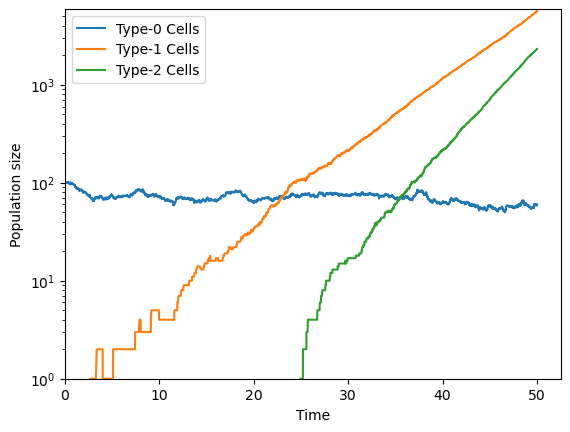

In [58]:
t_max = 50
cell_populations = reset()

ts, pops = branching_process(cell_populations, t_max)

for j in range(K):
	plt.plot(ts,pops[:,j],label = f"Type-{j} Cells")

plt.xlabel("Time")
plt.ylabel("Population size")
plt.xlim(left = 0)
plt.ylim(bottom = 1)
plt.yscale("log")
plt.legend()
plt.show()